In [1]:
from concurrent.futures import ProcessPoolExecutor, as_completed

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
cpu = 10

lgp_cutoff = 8
log2odds_cutoff = 1

## Load

### Pairwise Motif Enrichment

In [3]:
motif_enrichment_results = pd.read_msgpack('PairwiseMotifEnrichment.msg')
motif_enrichment_results['log2odds'] = np.log2(
    motif_enrichment_results['oddsratio'])
motif_enrichment_results = motif_enrichment_results[
    (motif_enrichment_results['-lgp'] > lgp_cutoff)
    & (motif_enrichment_results['log2odds'].abs() > log2odds_cutoff)].copy()

/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3326: FutureWarning: The read_msgpack is deprecated and will be removed in a future version.
It is recommended to use pyarrow for on-the-wire transmission of pandas objects.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [4]:
def judge_row(row):
    if row['log2odds'] < 0:
        return pd.Series({'enrich': row['ClusterB'], 'null': row['ClusterA']})
    else:
        return pd.Series({'enrich': row['ClusterA'], 'null': row['ClusterB']})


motif_sig_judge = motif_enrichment_results.apply(judge_row, axis=1)

In [5]:
motif_sig_judge['enrich'].unique()

array(['IT-L4+MOp-2', 'IT-L4+SSp-3', 'IT-L4+SSp-4', 'IT-L4+MOp-1',
       'IT-L4+SSp-5', 'IT-L4+MOs-3', 'IT-L4+MOs-1', 'IT-L23+SSp-2',
       'IT-L23+SSp-3', 'IT-L23+SSs-2', 'IT-L23+MOp-2', 'IT-L23+MOp-3',
       'IT-L23+SSp-1', 'IT-L23+SSs-1', 'IT-L23+SSp-4', 'IT-L23+MOs-3',
       'IT-L23+MOs-2', 'IT-L23+SSp-5', 'IT-L23+MOp-1', 'IT-L23+MOs-1',
       'IT-L23+MOp-4', 'IT-L23+PFC-1', 'IT-L23+ACA-3', 'IT-L23+PFC-2',
       'IT-L23+AI', 'IT-L23+ORB', 'IT-L23+ACA-1', 'IT-L23+ACA-2',
       'IT-L5+MOs-2', 'IT-L6+SSp-3', 'IT-L6+SSp-2', 'IT-L6+ACA-2',
       'IT-L6+SSp-1', 'IT-L6+SSp-4', 'IT-L6+ACA-3', 'IT-L6+SSs-2',
       'IT-L6+SSp-5', 'IT-L6+ACA-1', 'IT-L5+SSs-2', 'IT-L6+MOs-2',
       'IT-L5+SSp-2', 'IT-L5+SSp-3', 'IT-L6+AI', 'IT-L6+PFC-2',
       'IT-L6+SSs-1', 'IT-L5+MOp-2', 'IT-L5+SSs-1', 'IT-L6+PFC-1',
       'IT-L5+SSp-4', 'IT-L4+SSs-1', 'IT-L6+MOp-2', 'IT-L5+MOp-3',
       'IT-L6+MOp-3', 'IT-L6+MOs-3', 'IT-L5+SSp-1', 'IT-L5+MOs-3',
       'IT-L6+MOp-4', 'IT-L5+SSp-5', 'IT-L4+MOp-4

### Dendrogram

In [6]:
node_cluster_dict = joblib.load(
    '/home/hanliu/project/mouse_rostral_brain/study/ITSpatial-DissectionRegion/DMG/ITSpatial.pvclust.non_singleton_node_dict.lib'
)


In [7]:
node_possible_count = {}
for node, sub_dict in node_cluster_dict.items():
    possible_pairs = len(sub_dict['left']) * len(sub_dict['right'])
    node_possible_count[node] = possible_pairs
node_possible_count = pd.Series(node_possible_count)

### Gene Meta

In [8]:
gene_meta = pd.read_csv(
    '/home/hanliu/ref/mouse/gencode/vm22/gencode.vM22.annotation.gene.flat.tsv.gz',
    sep='\t',
    index_col='gene_id')
gene_name_to_id = {v: k for k, v in gene_meta['gene_name'].items()}

## Assign motif to tree

In [9]:
def calculate_node_portion(sub_df):
    nodes_records = {}
    for k, v in node_cluster_dict.items():
        left = [i.replace(' ', '_') for i in v['left']]
        right = [i.replace(' ', '_') for i in v['right']]

        # left enrich, right null
        judge_from_left = sub_df['enrich'].apply(lambda i: i in left)
        judge_to_right = sub_df['null'].apply(lambda i: i in right)

        # right enrich, left hyper
        judge_from_right = sub_df['enrich'].apply(lambda i: i in right)
        judge_to_left = sub_df['null'].apply(lambda i: i in left)

        # this two cancel each other, use the remaining abs as real hits
        # positive means left hypo, negative means right hypo
        total = (judge_from_left & judge_to_right).sum() -\
                (judge_from_right & judge_to_left).sum()
        nodes_records[k] = total
    nodes_records = pd.Series(nodes_records) / node_possible_count
    return nodes_records

In [10]:
total_result = {}
with ProcessPoolExecutor(cpu) as executor:
    futures = {}
    for motif, sub_df in motif_sig_judge.groupby(motif_sig_judge.index):
        future = executor.submit(calculate_node_portion, sub_df)
        futures[future] = motif
        
    for future in as_completed(futures):
        result = future.result()
        gene = futures[future]
        total_result[gene] = result
total_result = pd.DataFrame(total_result)

In [11]:
mask_cutoff = 0.3

masked_result = total_result.copy()
masked_result[masked_result.abs() < 0.3] = 0

In [12]:
# gene that assign to at least one node
((masked_result != 0).sum(axis=0) != 0).sum()

174

In [13]:
# node that has at least 5 genes
((masked_result != 0).sum(axis=1) > 5).sum()

17

In [14]:
masked_result.apply(lambda i: 0 if i.abs().max() == 0 else i.abs().idxmax(), axis=0)

MA0003.4      0
MA0018.4      0
MA0025.2      0
MA0039.4      0
MA0032.2    142
           ... 
MA1638.1    142
MA1652.1      0
MA1653.1      0
MA1642.1    142
MA1683.1    142
Length: 354, dtype: int64

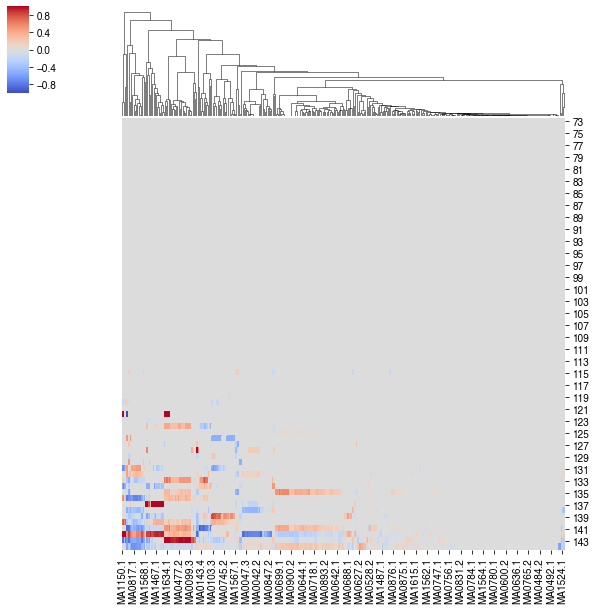

In [15]:
sns.clustermap(total_result, row_cluster=False, cmap='coolwarm')

In [16]:
total_result.to_msgpack('NodeMotifResults.msg')

/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: to_msgpack is deprecated and will be removed in a future version.
It is recommended to use pyarrow for on-the-wire transmission of pandas objects.
  """Entry point for launching an IPython kernel.
